# What is DQN?
So I asked my friend GPT to explain DQN to a person who only knows about linear approximators, and here is what I found.  

Instead of hand-crafting features using tile coding or making them by ourselves, why not let the deep neural network learn them?  
DQN (Deep Q-Network) approximates the Q-functions instead of storing Q-values like tabular Q-Learning.

# Why go with DQN?
Now we were struggling with making features using either tile coding or making the features ourselves. We do not have enough time before submission to make the features ourselves. Results and analysis are needed.   
Therefore, we are going to use the help of DRL by using CNN (Convolutional Neural Network) for image processing and DQN to approximate whatever we get from CNN.  
Also 2 of our team members took Machine Learning, so we are a bit familiar with CNN.  
We are hoping for less training time so we can test on different alphas, gammas, and maybe rewards. 

In [1]:
# First lets work on making the CNN
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import gymnasium as gym
import random
import cv2
from collections import deque

Here are explanations for the numbers we are using for the CNN model:
- Fitlers: 
    For filters we are going with 32, 64, 64 as it is a very common setup for CNN. We start 32 to detect edges and shapes. Then, going 64 fitlers twice to detect more complex shapes.
- Kernel size:
    For kernel size we start with a big enough size of 8x8 matrix that slides through the images. Calculation and operations are done to detect features. Then we decrease it to 4x4, and end with 3x3.
- Strides:
    Strides determine how far we move each time. We start with a big one 4, which aggressibely reduces spacial size. Then, 2 to further downsample it. Finally, we end with one stride 

In [2]:
# Define the CNN model
def create_cnn_model(input_shape, num_actions):
    model = tf.keras.models.Sequential([
        tf.keras.layers.Input(shape=input_shape),
        # Rescaling is for normalizing the pixel values to be between 0 and 1
        tf.keras.layers.Rescaling(1./255),
        tf.keras.layers.Conv2D(32, kernel_size=8, strides=4, activation="relu"),
        tf.keras.layers.Conv2D(64, kernel_size=4, strides=2, activation="relu"),
        tf.keras.layers.Conv2D(64, kernel_size=3, strides=1, activation="relu"),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(512, activation="relu"),
        # For DQN we dont need to use activation function
        tf.keras.layers.Dense(num_actions)
    ])
    return model


In [3]:
# helper classes and functions for DQN

# Replay Buffer for DQN
class ReplayBuffer:
    def __init__(self, size):
        self.buffer = deque(maxlen=size)

    def add(self, experience):
        self.buffer.append(experience)

    def sample(self, batch_size):
        return random.sample(self.buffer, batch_size)
    
    def ready(self, batch_size):
        return len(self.buffer) >= batch_size
    
IMG_SIZE = 96
CROP_HEIGHT_PERCENTAGE = 0.12

# Preprocess the image
def preprocess(image):
    image = image[:int(image.shape[0] * (1-CROP_HEIGHT_PERCENTAGE)), :, :]
    image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    image = cv2.resize(image, (IMG_SIZE, IMG_SIZE))
    image = image / 255.0
    return image

def skip_frames(env, skip=50):
    for _ in range(skip):
        action = env.action_space.sample()
        obs, _, _, _, _ = env.step(action)
    return obs

# Train step
@tf.function
def train_step(model, target_model, optimizer, states, actions, rewards, next_states, dones, gamma):
    future_q = tf.reduce_max(target_model(next_states), axis=1)
    target_q = rewards + (1.0 - dones) * gamma * future_q
    with tf.GradientTape() as tape:
        q_values = tf.reduce_sum(model(states) * tf.one_hot(actions, model.output_shape[-1]), axis=1)
        loss = tf.keras.losses.MSE(target_q, q_values)
    grads = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))
    return loss

In [4]:
class DQNAgent:
    def __init__(self, input_shape, num_actions, alpha=0.1, gamma=0.9,
                 epsilon=1.0, epsilon_min=0.1, epsilon_decay=0.995,
                 batch_size=64, buffer_size=100_000, target_update_freq=1000):
        self.input_shape = input_shape
        self.num_actions = num_actions
        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_min = epsilon_min
        self.epsilon_decay = epsilon_decay
        self.batch_size = batch_size
        self.target_update_freq = target_update_freq
        self.steps = 0

        self.policy_net = create_cnn_model(input_shape, num_actions)
        self.target_net = create_cnn_model(input_shape, num_actions)
        self.target_net.set_weights(self.policy_net.get_weights())

        self.optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=alpha)
        self.buffer = ReplayBuffer(buffer_size)

    def select_action(self, state):
        if np.random.rand() < self.epsilon:
            return np.random.randint(self.num_actions)
        state_input = np.expand_dims(state, axis=0)
        q_values = self.policy_net.predict(state_input, verbose=0)
        return np.argmax(q_values)

    def store_experience(self, experience):
        self.buffer.add(experience)

    def update_target_network(self):
        self.target_net.set_weights(self.policy_net.get_weights())

    def decay_epsilon(self):
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

    def train(self):
        if not self.buffer.ready(self.batch_size):
            return
        batch = self.buffer.sample(self.batch_size)
        s, a, r, s2, d = map(np.array, zip(*batch))
        train_step(
            self.policy_net, self.target_net, self.optimizer,
            tf.convert_to_tensor(s, dtype=tf.float32),
            tf.convert_to_tensor(a, dtype=tf.int32),
            tf.convert_to_tensor(r, dtype=tf.float32),
            tf.convert_to_tensor(s2, dtype=tf.float32),
            tf.convert_to_tensor(d, dtype=tf.float32),
            self.gamma
        )
        self.steps += 1
        if self.steps % self.target_update_freq == 0:
            self.update_target_network()

    def run_episode(self, env):
        obs, _ = env.reset()
        obs = skip_frames(env)
        state = preprocess(obs)
        done, total_reward = False, 0

        while not done:
            action = self.select_action(state)
            next_obs, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            next_state = preprocess(next_obs)
            self.store_experience((state, action, reward, next_state, float(done)))
            self.train()
            state = next_state
            total_reward += reward

        self.decay_epsilon()
        return total_reward
    
    def save_model(self, filepath):
        """Save the model weights to a file"""
        self.policy_net.save_weights(filepath)
        print(f"Model saved to {filepath}")

    def load_model(self, filepath):
        """Load the model weights from a file"""
        self.policy_net.load_weights(filepath)
        self.target_net.load_weights(filepath)  # Also update target network
        print(f"Model loaded from {filepath}")

    def save_checkpoint(self, filepath):
        """Save a complete checkpoint including model weights and training state"""
        checkpoint = {
            'policy_net_weights': self.policy_net.get_weights(),
            'target_net_weights': self.target_net.get_weights(),
            'epsilon': self.epsilon,
            'steps': self.steps
        }
        tf.keras.models.save_model(self.policy_net, filepath)
        print(f"Checkpoint saved to {filepath}")

    def load_checkpoint(self, filepath):
        """Load a complete checkpoint including model weights and training state"""
        self.policy_net = tf.keras.models.load_model(filepath)
        self.target_net = tf.keras.models.load_model(filepath)
        print(f"Checkpoint loaded from {filepath}")


Episode 1 finished with reward -63.750000000000945
Episode 2 finished with reward -60.98639455782398
Episode 3 finished with reward -63.652037617555806
Episode 4 finished with reward -63.926553672317375
Episode 5 finished with reward -65.00000000000077
Episode 6 finished with reward -57.54681647940164
Episode 7 finished with reward -56.9047619047627
Episode 8 finished with reward -64.32515337423402
Episode 9 finished with reward -53.95522388059785
Episode 10 finished with reward -54.55882352941259
Episode 11 finished with reward -57.96296296296391
Episode 12 finished with reward -57.962962962963864
Episode 13 finished with reward -54.4594594594603
Episode 14 finished with reward -68.52941176470657
Episode 15 finished with reward -63.83852691218219
Episode 16 finished with reward -62.320261437909345
Episode 17 finished with reward -63.35443037974782
Episode 18 finished with reward -62.532467532468516
Episode 19 finished with reward -53.955223880597806
Episode 20 finished with reward -57

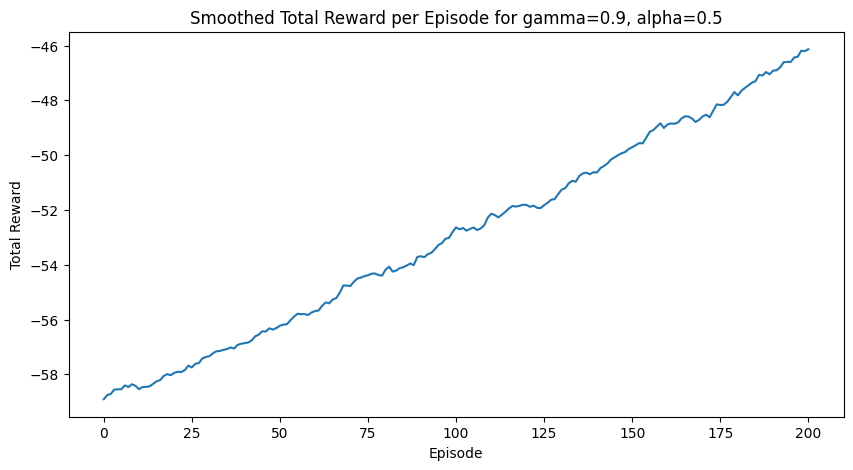

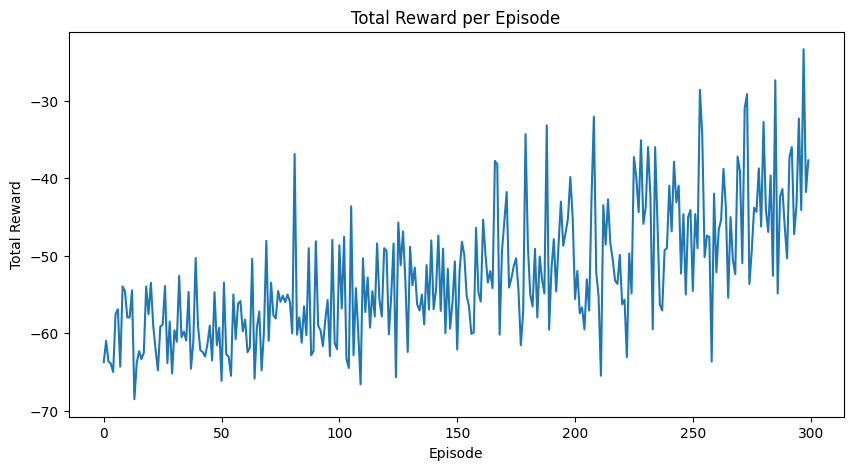

In [5]:
# --- PLOTTING FUNCTION ---
def plot_rewards(rewards, smoothing_window=100, save_path="plots",alpha=0.1,gamma=0.9,episodes=1000):
    smoothed = np.convolve(rewards, np.ones(smoothing_window)/smoothing_window, mode='valid')
    plt.figure(figsize=(10, 5))
    plt.plot(smoothed)
    plt.title(f"Smoothed Total Reward per Episode for gamma={gamma}, alpha={alpha}")
    plt.xlabel("Episode")
    plt.ylabel("Total Reward")
    plt.savefig(f"{save_path}/smoothed_rewards.png")
    plt.show()

    plt.figure(figsize=(10, 5))
    plt.plot(rewards)
    plt.title("Total Reward per Episode")
    plt.xlabel("Episode")
    plt.ylabel("Total Reward")
    plt.savefig(f"{save_path}/rewards.png")
    plt.show()

def main():
    num_episodes = 300
    alpha = 0.1
    gamma = 0.7
    # Define the environment
    env = gym.make("CarRacing-v3", continuous=False)
    action_space = env.action_space.n
    state_space = (IMG_SIZE,IMG_SIZE,1)
    agent = DQNAgent(state_space, action_space,alpha=alpha,gamma=gamma)

    rewards = []
    for episode in range(num_episodes):
        total_reward = agent.run_episode(env)
        rewards.append(total_reward)
        print(f"Episode {episode + 1} finished with reward {total_reward}")
        if (episode + 1) % 50 == 0:
            checkpoint_path = f"checkpoints/dqn_model_episode_{episode+1}"
            agent.policy_net.save_weights(checkpoint_path)
            print(f"Saved model weights to {checkpoint_path}")

    # Save final model
    final_path = "checkpoints/dqn_model_final"
    agent.policy_net.save_weights(final_path)
    print(f"Saved final model weights to {final_path}")
    # plotting 
    plot_rewards(rewards,alpha=alpha,gamma=gamma,episodes=num_episodes)

if __name__ == "__main__":
    main()
